# 4. Human myocardial infarction atlas
Kuppe, C., Ramirez Flores, R. O., Li, Z., Hayat, S., Levinson, R. T., Liao, X., ... & Kramann, R. (2022). Spatial multi-omic map of human myocardial infarction. Nature, 608(7924), 766-777.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro
from scanpro.utils import convert_counts_to_df

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

------------------

## Read data

In [3]:
human_MI_counts = pd.read_csv("data/human_MI_counts.tsv", sep="\t")
human_MI = convert_counts_to_df(human_MI_counts, column_name="cell_type")

In [4]:
human_MI.head()

,Sample,Sex,Patient_group,Zone,cell_type
cell_1,CK158,Female,Myogenic,Control,Age
cell_2,CK158,Female,Myogenic,Control,Age
cell_3,CK158,Female,Myogenic,Control,Age
cell_4,CK158,Female,Myogenic,Control,Age
cell_5,CK158,Female,Myogenic,Control,Age


-------------

## Compare Ischaemic zone vs Control

### With replicates

In [5]:
res_snrna = scanpro.scanpro(human_MI, samples_col='Sample',
                            clusters_col='cell_type', conds_col='Zone', 
                            conditions=['Control','Ischaemic'])

res_snrna.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_Control,mean_props_Ischaemic,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
Adipocyte,0.002705,0.000354,0.002021,0.175079,0.033791,0.973482,0.973482
Age,0.008017,0.004990,0.025658,0.194495,-3.246420,0.005321,0.031927
Cardiomyocyte,0.333652,0.440201,0.148631,2.961711,2.807551,0.013086,0.052343
Cycling cells,0.015413,0.005400,0.061831,0.087341,-5.753884,0.000036,0.000427
Endothelial,0.169045,0.146213,0.201267,0.726461,-1.197520,0.249371,0.332495
Fibroblast,0.244687,0.224765,0.265706,0.845915,-0.565938,0.579662,0.632358
Lymphoid,0.026192,0.012710,0.041458,0.306584,-2.220140,0.041952,0.083904
Mast,0.003719,0.003479,0.002997,1.160823,1.317122,0.207230,0.310845
Myeloid,0.109038,0.074417,0.179912,0.413629,-2.431025,0.027823,0.083469


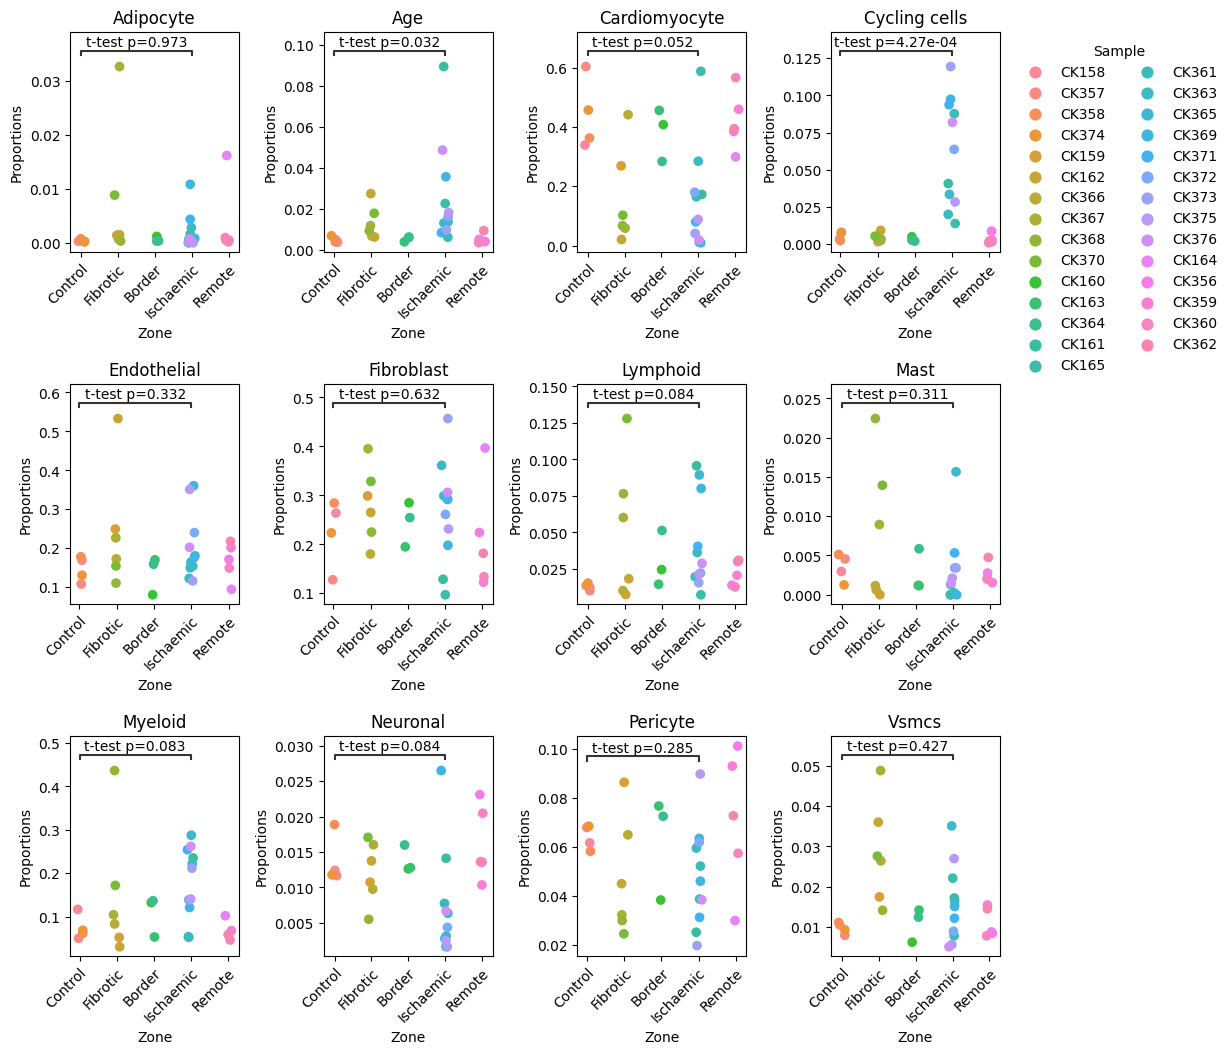

In [6]:
res_snrna.plot(n_columns=4, save=f"{FIG_PATH}/humanMI_rep_all.pdf")

In [7]:
res_snrna.results.to_csv("results/humanMI_scanpro_rep_logit.tsv", sep="\t")

In [8]:
# transform=arcsin
res_snrna = scanpro.scanpro(human_MI, samples_col='Sample',
                            clusters_col='cell_type', conds_col='Zone', 
                            conditions=['Control','Ischaemic'], transform="arcsin")
res_snrna.results.to_csv("results/humanMI_scanpro_rep_arcsin.tsv", sep="\t")

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


### Without replicates

In [9]:
res_snrna_boot = scanpro.scanpro(human_MI, clusters_col='cell_type',
                                 conds_col='Zone', n_reps=8, conditions=['Control','Ischaemic'],
                                 transform='logit')
res_snrna_boot.results.to_csv("results/humanMI_scanpro_norep_logit.tsv", sep="\t")

res_snrna_boot.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 43.54 seconds


,baseline_props,mean_props_Control,mean_props_Ischaemic,p_values
clusters,,,,
Adipocyte,0.002705,0.000163,0.001223,0.132883
Age,0.008017,0.003932,0.015535,0.128031
Cardiomyocyte,0.333652,0.440174,0.136985,0.000426
Cycling cells,0.015413,0.004888,0.063079,0.001907
Endothelial,0.169045,0.142232,0.185551,0.216036
Fibroblast,0.244687,0.223947,0.295488,0.207380
Lymphoid,0.026192,0.010763,0.033782,0.142556
Mast,0.003719,0.002821,0.002656,0.576327
Myeloid,0.109038,0.072483,0.182729,0.019990


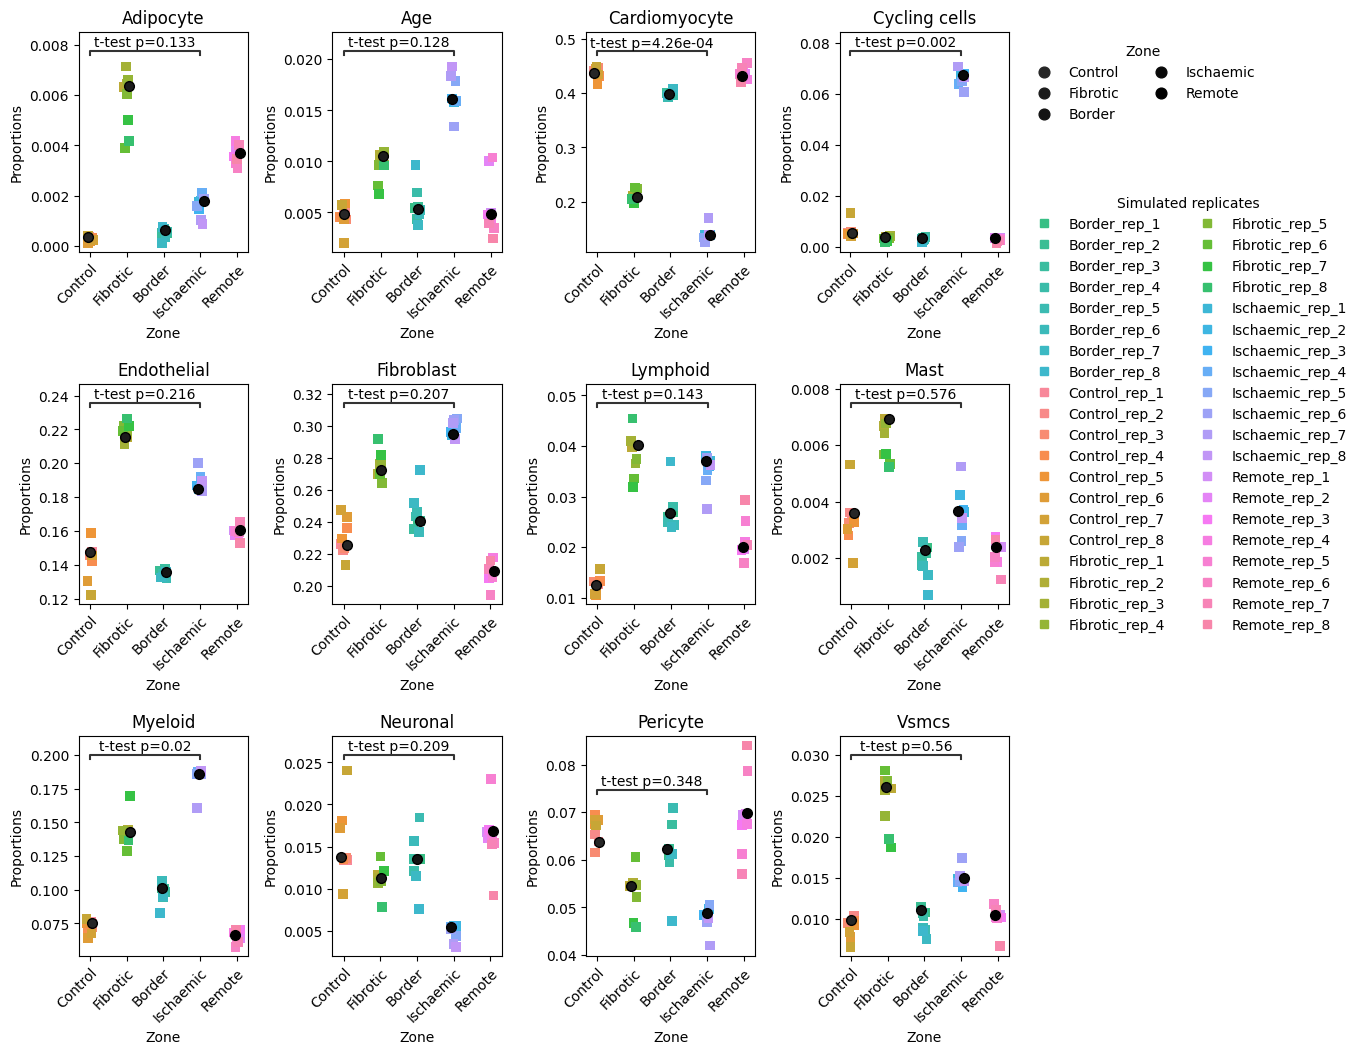

In [10]:
res_snrna_boot.plot(n_columns=4, save=f"{FIG_PATH}/humanMI_norep_all.pdf")

In [11]:
res_snrna_boot = scanpro.scanpro(human_MI, clusters_col='cell_type',
                                 conds_col='Zone', n_reps=8, conditions=['Control','Ischaemic'],
                                 transform='arcsin')

res_snrna_boot.results
res_snrna_boot.results.to_csv("results/humanMI_scanpro_norep_arcsin.tsv", sep="\t")

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 42.77 seconds


-------------------

# Run propeller

In [12]:
#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

In [13]:
human_MI_sub = human_MI[human_MI["Zone"].isin(['Control','Ischaemic'])]

In [14]:
%%R -i human_MI_sub -o propeller_results_logit -o propeller_results_arcsin
library(speckle)

propeller_results_logit = propeller(clusters = human_MI_sub$cell_type, sample = human_MI_sub$Sample, 
                                    group = human_MI_sub$Zone, transform="logit")
propeller_results_arcsin = propeller(clusters = human_MI_sub$cell_type, sample = human_MI_sub$Sample, 
                                    group = human_MI_sub$Zone, transform="asin")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 
Performing logit transformation of proportions
group variable has 2 levels, t-tests will be performed
Performing arcsin square root transformation of proportions
group variable has 2 levels, t-tests will be performed


In [15]:
propeller_results_logit.to_csv("results/humanMI_propeller_rep_logit.tsv", sep="\t")
propeller_results_arcsin.to_csv("results/humanMI_propeller_rep_arcsin.tsv", sep="\t")

-------------

## Compare results with/without replicates

In [16]:
# get results with and without replicates
compare = {'scanpro': -np.log10(res_snrna.results.iloc[:,-1]),
           'scanpro_noRep': -np.log10(res_snrna_boot.results.iloc[:,-1])}

compare = pd.DataFrame(compare, index=res_snrna.results.index)

compare

,scanpro,scanpro_noRep
clusters,,
Adipocyte,0.312384,0.628133
Age,1.001171,1.380599
Cardiomyocyte,1.522336,6.117591
Cycling cells,2.087523,4.150718
Endothelial,0.536674,1.101411
Fibroblast,0.312080,1.184616
Lymphoid,0.884664,1.598165
Mast,0.312080,0.258473
Myeloid,1.127413,3.571485


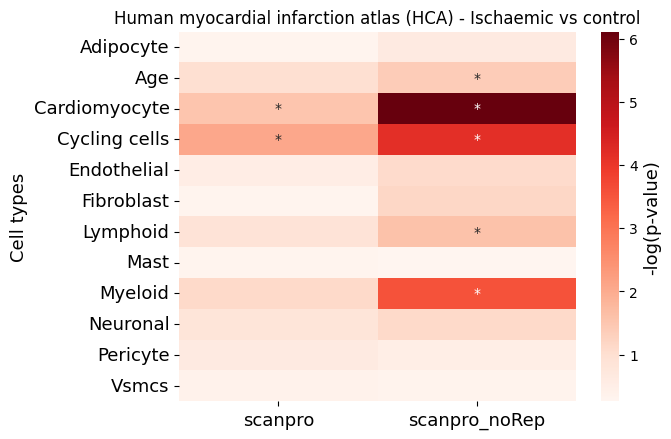

In [17]:
# annotation for heatmap
annot = {'scanpro': ['*' if value < 0.05 else '' for value in res_snrna.results.iloc[:,-1].to_list()],
         'scanpro_noRep': ['*' if value < 0.05 else '' for value in res_snrna_boot.results.iloc[:,-1].to_list()]}

ax = sns.heatmap(compare, annot=pd.DataFrame(annot), fmt='', 
                 cmap='Reds', 
                 cbar_kws={'label': '-log(p-value)'})
ax.set_ylabel('Cell types', fontsize=13)
ax.set_title("Human myocardial infarction atlas (HCA) - Ischaemic vs control")

plt.tick_params(axis='both', which='major', labelsize=13)
ax.figure.axes[-1].yaxis.label.set_size(13)

#plt.savefig(f'{FIG_PATH}/ischaemic_vs_ctrl.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'{FIG_PATH}/ischaemic_vs_ctrl.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [18]:
res_snrna_boot.props

cell_type,Adipocyte,Age,Cardiomyocyte,Cycling cells,Endothelial,Fibroblast,Lymphoid,Mast,Myeloid,Neuronal,Pericyte,Vsmcs
Zone,,,,,,,,,,,,
Border,0.000638,0.005295,0.397807,0.003380,0.135669,0.240547,0.026698,0.002291,0.100973,0.013481,0.062183,0.011040
Control,0.000358,0.004873,0.437337,0.005326,0.147491,0.225763,0.012587,0.003583,0.075358,0.013758,0.063749,0.009817
Fibrotic,0.006367,0.010501,0.209437,0.003583,0.215638,0.272579,0.040129,0.006945,0.143042,0.011217,0.054516,0.026045
Ischaemic,0.001798,0.016095,0.138862,0.067462,0.184607,0.295160,0.036956,0.003653,0.186005,0.005508,0.048913,0.014982
Remote,0.003681,0.004858,0.432364,0.003232,0.160738,0.209596,0.020085,0.002392,0.065954,0.016834,0.069784,0.010482


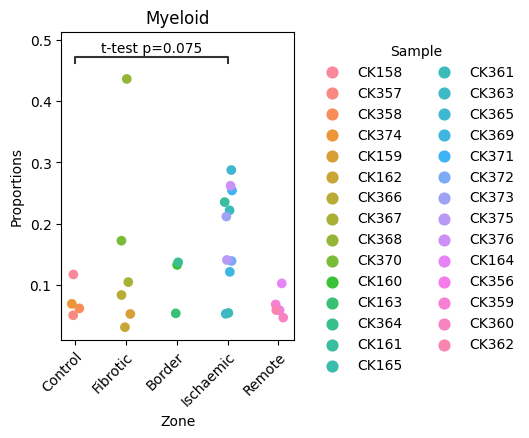

In [19]:
res_snrna.plot(clusters=["Myeloid"])

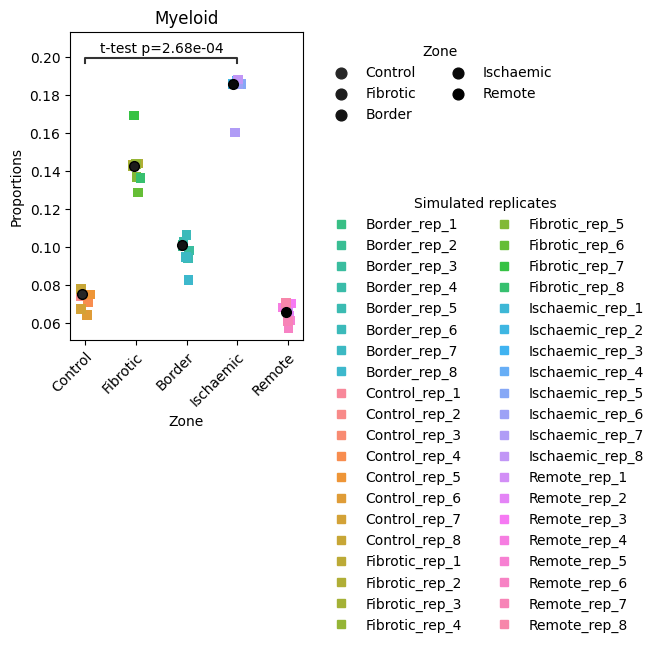

In [20]:
res_snrna_boot.plot(clusters=["Myeloid"])